**Importando librerías**

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from sympy import Min, Max

from devito import configuration, Function, norm, mmax, Eq, Operator

from examples.seismic import demo_model, Model, plot_velocity, plot_image, plot_shotrecord, AcquisitionGeometry, Receiver
from examples.seismic.acoustic import AcousticWaveSolver


configuration['log-level'] = "ERROR"



**Parametros de adquisición**

In [2]:
nshots = 22  # Numero de disparos
nreceivers = 70  # Numero de receptores por disparo
fwi_iterations = 100 # Número de iteraciones de FWI

shape = (70, 70)  # (nx, nz)
spacing = (10., 10.)  # espaciamiento en m
origin = (0., 0.)  # origen

t0 = 0. #Tiempo inicial
tn = 1000. #Tiempo final (ms)
f0 = 0.010 #Frecuencia: 10 Hertzh

**Modelo verdadero de capas planas isotrópicas acústicas**

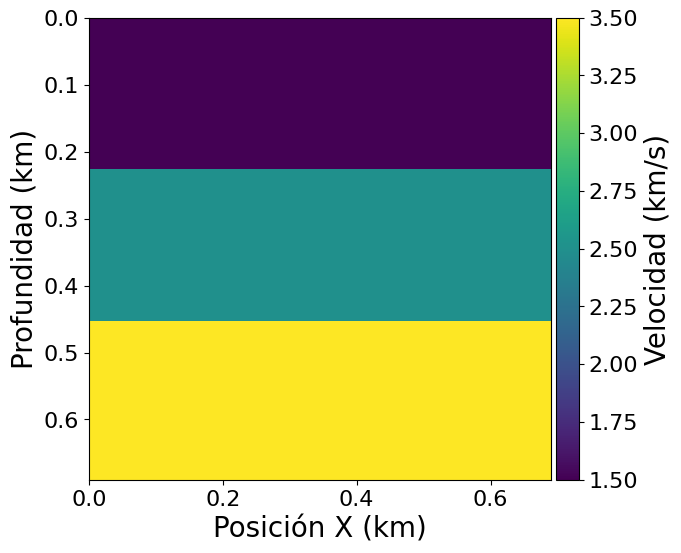

In [3]:
model = demo_model('layers-isotropic', dtype=np.float32,
                   origin=origin, shape=shape, spacing=spacing, nbl=40)

plot_velocity(model)

**Creación del modelo inicial (creado en InversionNet)**

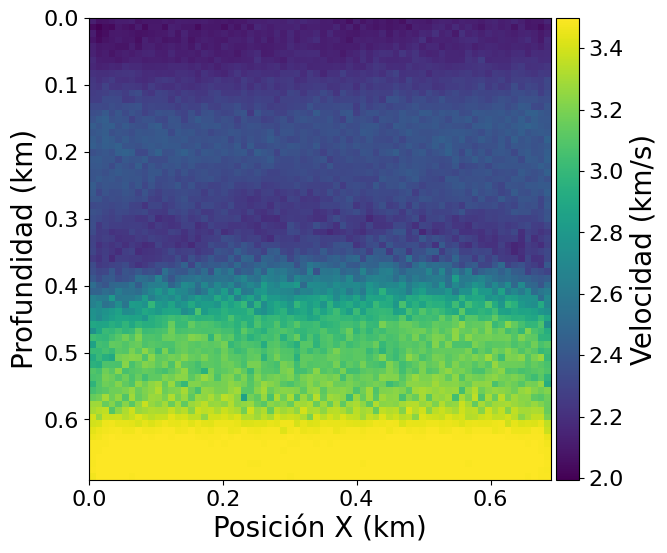

In [4]:
m = np.load('modInvNET_7070.npy') #Modelo en m/s
m=m/1000 #Modelo en km/s
m = np.swapaxes(m,1,0) #Se se voltea el modelo (la predicción lo generó así)

#Convirtiendo el modelo en un objeto SeismicModel
model0 = Model(vp=m, origin=origin, spacing=spacing, dtype=np.float32,
               shape=shape, space_order=2, bcs='damp', nbl=40)  

plot_velocity(model0)

**Graficando la geometría de adquisición**

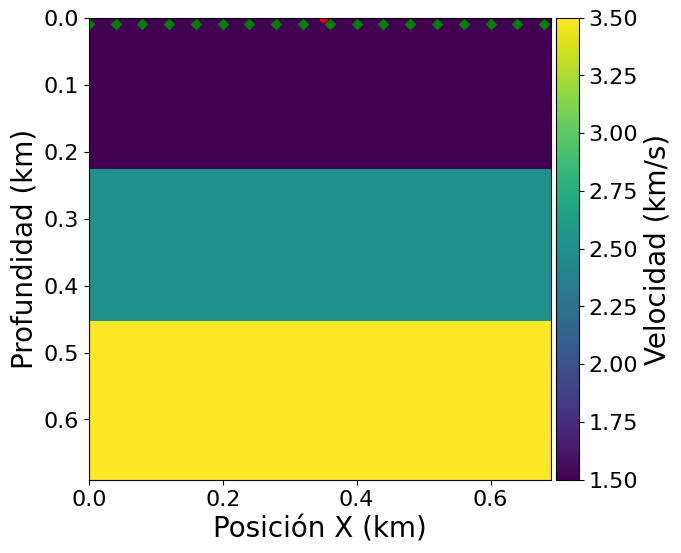

In [5]:
# Posiciones de las fuentes
src_coordinates = np.empty((1, 2))
src_coordinates[:,0] = 350 #X
src_coordinates[:,1] = 0  #Y

# Posiciones de los receptores
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers) #X
rec_coordinates[:, 1] =  10 #Y

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])


**Forward modelling**

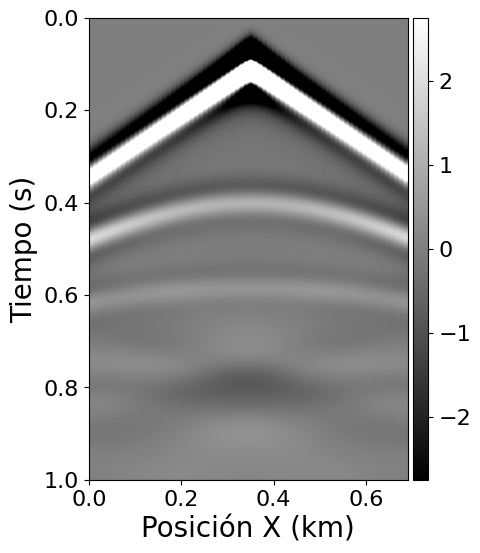

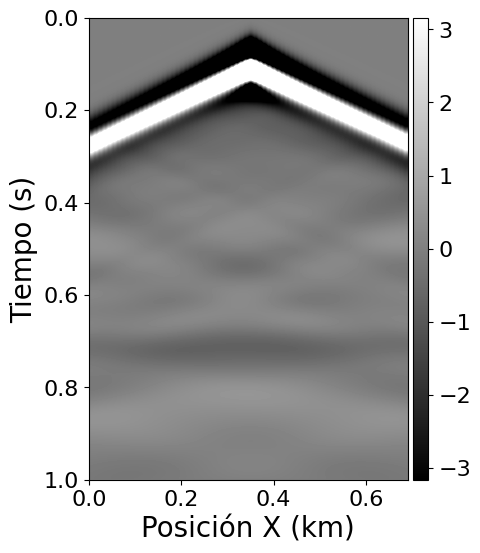

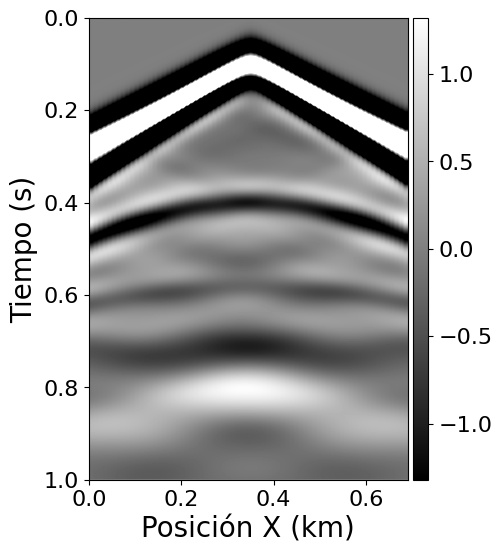

In [6]:
#Configuración del operador directo
solver = AcousticWaveSolver(model, geometry, space_order=4)

true_d, _, _ = solver.forward(vp=model.vp)

smooth_d, _, _ = solver.forward(vp=model0.vp)

#Graficar los datos sísmicos
plot_shotrecord(true_d.data, model, t0, tn) #Datos observados
plot_shotrecord(smooth_d.data, model, t0, tn) #Datos sintéticos
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) #Diferencia entre estos datos



**Preparación de las fuentes para generar todos los shots iterativamente para el cálculo de gradiente**

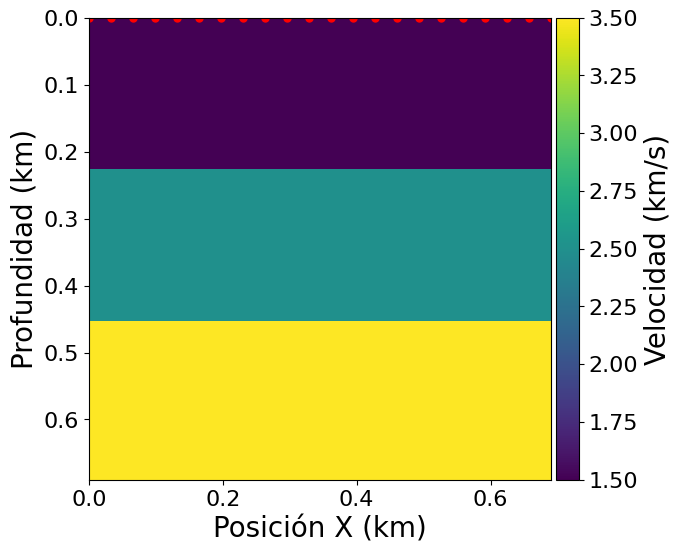

In [7]:
#Preparar la iteración de fuentes para el cálculo de gradiente
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0, model.domain_size[0], num=nshots) #X
source_locations[:, 1] = 0 #Y

#Se muestran TODAS las fuentes
plot_velocity(model, source=source_locations)

**Cálculo de residuos y creación de la función del gradiente con objetivo norma l2 (función de costo)**

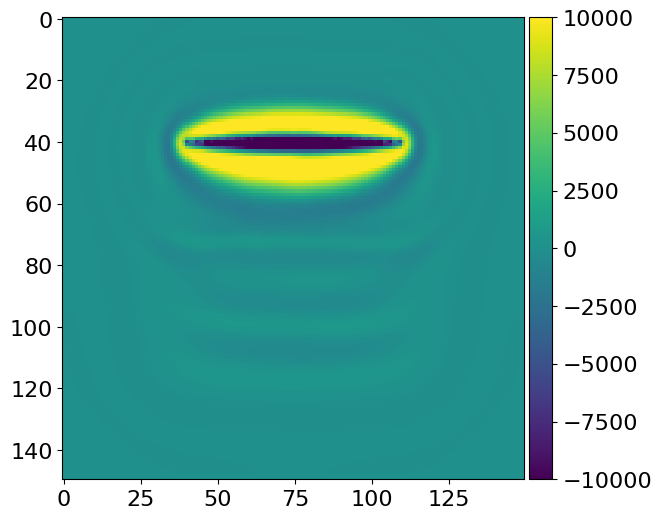

In [8]:
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        #Asegurar que las dimensiones y posiciones entre datos concuerdan
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        #Crear operador diferencial
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

def fwi_gradient(vp_in):    
   
    grad = Function(name="grad", grid=model.grid)

    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Se actualiza la posición de la fuente para cada iteración en el rango nshots
        geometry.src_positions[0,:] = source_locations[i,:]
        
        # Generar datos sintéticos
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        #Computar gradiente y actualizar la función objetivo (función de costo)
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2 #norma L2 (función de costo)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

#Computar gradiente del modelo inicial
ff, update = fwi_gradient(model0.vp)

#Gráfica del gradiente
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="viridis")

**Muestra lo que la actualización le hace al modelo**

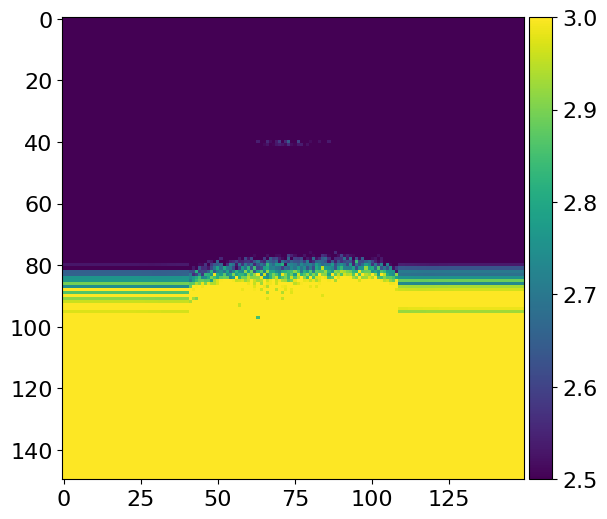

In [9]:
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="viridis")

**Actualización del modelo iterativamente con el método steepest descent**

La función de costo es 1680742.875000 en la iteración 1
La función de costo es 1623258.125000 en la iteración 2
La función de costo es 1570461.125000 en la iteración 3
La función de costo es 1521780.000000 en la iteración 4
La función de costo es 1476872.750000 en la iteración 5
La función de costo es 1435862.125000 en la iteración 6
La función de costo es 1399503.000000 en la iteración 7
La función de costo es 1368593.500000 en la iteración 8
La función de costo es 1342454.750000 en la iteración 9
La función de costo es 1320722.375000 en la iteración 10
La función de costo es 1302615.500000 en la iteración 11
La función de costo es 1287612.625000 en la iteración 12
La función de costo es 1275401.250000 en la iteración 13
La función de costo es 1265547.250000 en la iteración 14
La función de costo es 1257282.375000 en la iteración 15
La función de costo es 1250291.875000 en la iteración 16
La función de costo es 1244403.750000 en la iteración 17
La función de costo es 1239273.125000 en

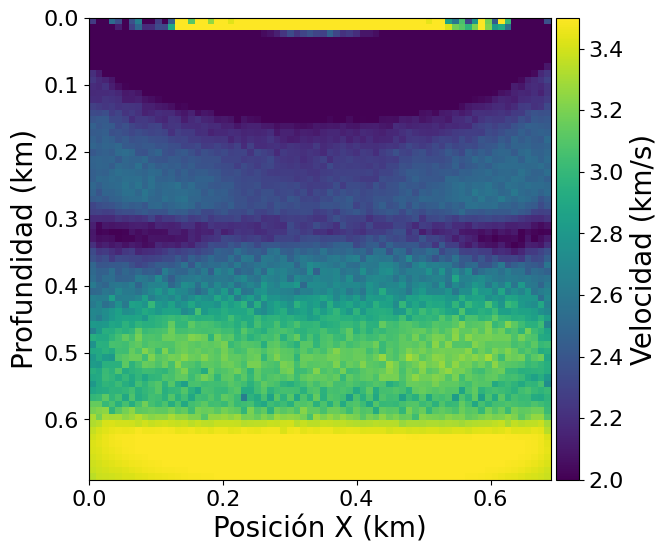

In [10]:
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
  
    phi, direction = fwi_gradient(model0.vp)
    
    history[i] = phi
    
    #longitud de paso (learning rate)
    alpha = .05 / mmax(direction)
    
    update_with_box(model0.vp , alpha , direction)
    
    print('La función de costo es %f en la iteración %d' % (phi, i+1))

#Modelo invertido
plot_velocity(model0)

**Decaimiento de la función de costo**

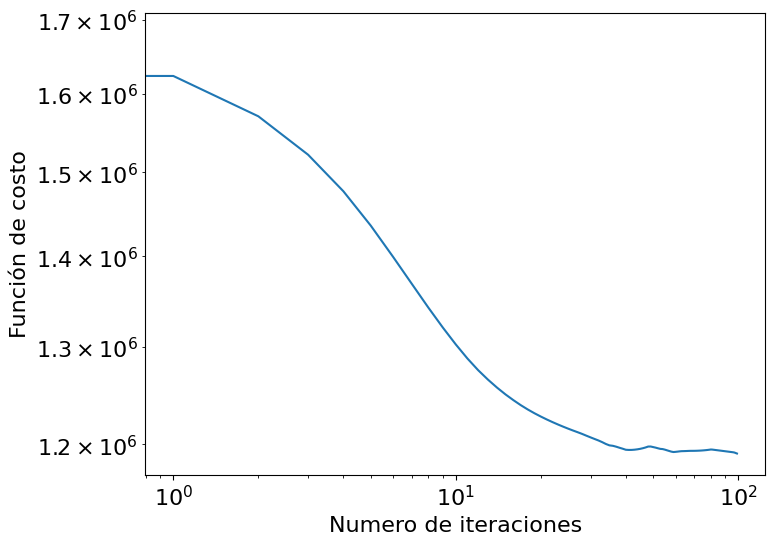

In [11]:
plt.figure()
plt.loglog(history)
plt.xlabel('Numero de iteraciones')
plt.ylabel('Función de costo')
plt.show()